<a href="https://colab.research.google.com/github/nicktz4/CSD/blob/main/485%5B2025%5D_HW5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#SVM Classification – Breast Cancer Dataset
In this exercise, you'll explore Support Vector Machines (SVMs) for binary classification using the Breast Cancer Wisconsin dataset. You'll go beyond just training a model — you'll investigate how SVMs make decisions, visualize decision boundaries, compare kernels, tune hyperparameters, and evaluate model confidence.

## Import necessary libraries

In [11]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.datasets import load_breast_cancer
import matplotlib.pyplot as plt


##Load & Explore the Breast Cancer Dataset

Use the built-in breast cancer dataset and get the basic characteristics for the data.

In [2]:

data = load_breast_cancer()


In [7]:
print(pd.DataFrame(data.target).value_counts()/len(data.target))

0
1    0.627417
0    0.372583
Name: count, dtype: float64


**Question:** What kind of classification problem is this? Are the classes balanced?

**Answer:** It is a binary classification. The classes are not balanced, 62% are in Class 1, and 38% are in Class 0.

## Preprocess the Data
Standardize the features and split the data.

In [9]:
X=data.data
y=data.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

x_scaler = StandardScaler()
X_train = x_scaler.fit_transform(X_train)
X_test = x_scaler.transform(X_test)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (455, 30)
y_train shape: (455,)
X_test shape: (114, 30)
y_test shape: (114,)


## Visualize with PCA (2D)

Use PCA to reduce the feature space to 2D and plot the points.

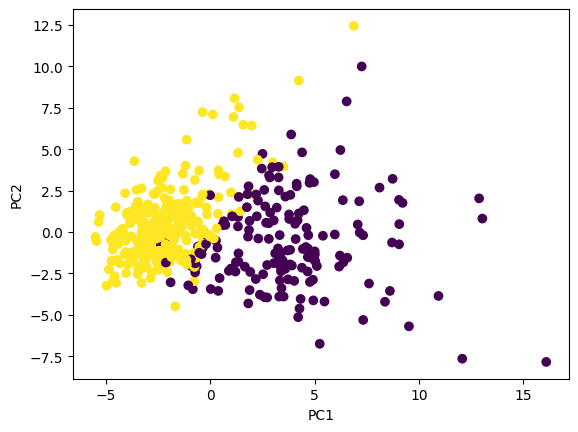

In [14]:
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

fig,ax = plt.subplots(1,1)
ax.scatter(X_train_pca[:,0],X_train_pca[:,1],c=y_train)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
plt.show()

**Question:** Can the classes be separated linearly in this reduced space?

**Answer:** They cannot perfectly linearly seperate in this reduced space, but we can get a good linear seperation with small number of errors. Visually, we can clearly distinguish the two groups (Yellow's and Purple's)

## Train & Evaluate a Linear SVM

Train an SVM with a linear kernel and evaluate its performance.

In [15]:
linear_svm = LinearSVC()
linear_svm.fit(X_train, y_train)
print("Linear SVM accuracy:", linear_svm.score(X_test, y_test))

Linear SVM accuracy: 0.956140350877193


## Visualize Decision Boundary (with PCA Projection)

Project the decision surface into PCA space (from previous task).


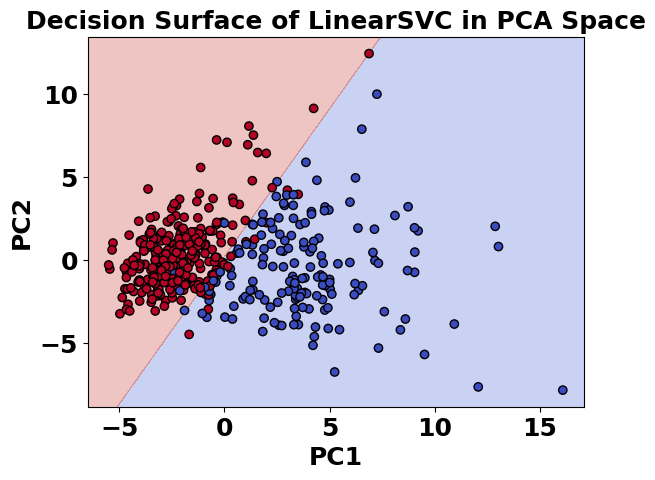

In [20]:
h = 0.02
x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))


grid_pca = np.c_[xx.ravel(), yy.ravel()]
grid_original = pca.inverse_transform(grid_pca) #Reconstruct the original space using the First 2 Components.

#Predict the reconstructed space
Z = linear_svm.predict(grid_original)
Z = Z.reshape(xx.shape)

import matplotlib as mpl
font_size = 18
mpl.rcParams.update({
    'font.size': font_size,           # Set default font size
    'font.weight': 'bold',     # Make all text bold
    'axes.labelweight': 'bold',  # Make axis labels bold
    'axes.titleweight': 'bold',  # Make title bold
    'xtick.labelsize': font_size,     # Tick label font size
    'ytick.labelsize': font_size,
    'xtick.labelcolor': 'black',
    'ytick.labelcolor': 'black',
    'axes.labelsize': font_size,
    'axes.titlesize': font_size,
})

fig, ax = plt.subplots()
ax.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)
ax.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap=plt.cm.coolwarm, edgecolor='k')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title('Decision Surface of LinearSVC in PCA Space')
plt.show()

## Train an SVM with RBF Kernel

Use a radial basis function kernel and compare its performance.

In [21]:
svc_rbf = SVC(kernel='rbf')
svc_rbf.fit(X_train, y_train)
print("RBF SVM accuracy:", svc_rbf.score(X_test, y_test))

RBF SVM accuracy: 0.9824561403508771


## Cross-Validation Comparison

Compare linear vs. RBF kernel using 5-fold cross-validation.

In [25]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
kf = KFold(n_splits=5, shuffle=True, random_state=42)
linear_scores = cross_val_score(linear_svm, X_train, y_train, cv=kf)
rbf_scores = cross_val_score(svc_rbf, X_train, y_train, cv=kf)
print("Linear SVM cross-validation scores:", linear_scores)
print("RBF SVM cross-validation scores:", rbf_scores)

print(f"Linear SVM Mean Accuracy: {np.mean(linear_scores)}")
print(f'RBF SVM Mean Accuracy: {np.mean(rbf_scores)}')


Linear SVM cross-validation scores: [0.95604396 0.97802198 0.98901099 0.96703297 0.96703297]
RBF SVM cross-validation scores: [0.95604396 0.97802198 0.97802198 0.98901099 0.96703297]
Linear SVM Mean Accuracy: 0.9714285714285715
RBF SVM Mean Accuracy: 0.9736263736263735


## Grid Search Hyperparameter Tuning (RBF)
Perform a grid search over `C` and `gamma` for the RBF kernel.

In [30]:
C = [0.5,1,2,10]
gamma = [0,0.1,'scale','auto',0.5,1,5,10]

from sklearn.model_selection import GridSearchCV
param_grid = {'C': C, 'gamma': gamma}
grid_search = GridSearchCV(svc_rbf, param_grid, cv=5)
grid_search.fit(X_train, y_train)
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

Best parameters: {'C': 1, 'gamma': 'scale'}
Best cross-validation score: 0.9758241758241759


## Evaluate Model Confidence (Decision Function)

Plot the decision function (histogram) or prediction confidence on the PCA plot.


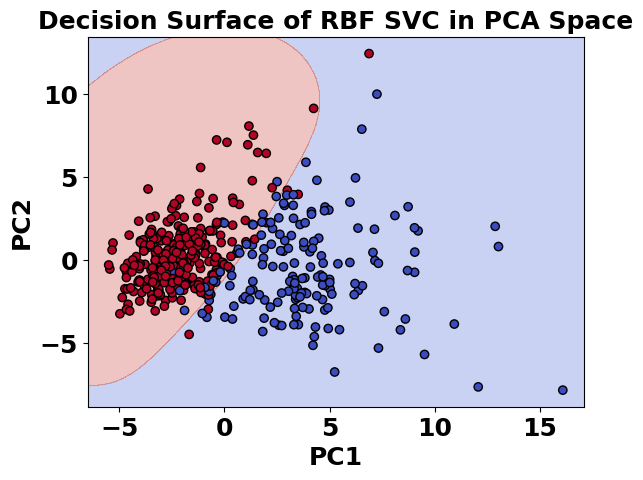

In [31]:
h = 0.02
x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))


grid_pca = np.c_[xx.ravel(), yy.ravel()]
grid_original = pca.inverse_transform(grid_pca) #Reconstruct the original space using the First 2 Components.

#Predict the reconstructed space
Z = grid_search.predict(grid_original)
Z = Z.reshape(xx.shape)

fig, ax = plt.subplots()
ax.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)
ax.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap=plt.cm.coolwarm, edgecolor='k')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title('Decision Surface of RBF SVC in PCA Space')
plt.show()

**Question:** Are predictions well-separated or clustered near the margin?

**Answer:** Near the margin, there are a lot of overlap points, so they cannot be very well seperated, but to avoid overfitting, this decision surface is more relaxed